In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
import numpy as np
import xgboost as xgb
import warnings

warnings.filterwarnings("ignore")

In [2]:
class CustomLinearRegression():
    def fit(self, X, y):
        """
        Fit linear model.

        Argument:
        X -- {array-like, sparse matrix} of shape (n_samples, n_features)
            Training data.

        y -- array-like of shape (n_samples,) or (n_samples, n_targets)
            Target values. Will be cast to X's dtype if necessary.
        """
        # Convert X to a NumPy array
        Z = np.array(X)
        
        # Add a column of ones to represent the intercept term
        ones_column = np.ones((Z.shape[0], 1))
        Z = np.column_stack((ones_column, Z))
        
        # Calculate the least squares estimation coefficients
        self.least_squares_estimation = np.dot(np.dot(np.linalg.inv(np.dot(Z.T, Z)), Z.T), y)
        
    def predict(self, X):
        """
        Predict using the linear model.

        Argument:
        X -- array-like or sparse matrix, shape (n_samples, n_features)
            Samples.

        Returns:
        prediction -- array, shape (n_samples,)
            Returns predicted values.
        """
        # Convert X to a NumPy array
        X = np.array(X)
        
        # Calculate predictions using the linear model equation
        prediction = self.least_squares_estimation[0] + np.dot(self.least_squares_estimation[1:], X.T)
        
        return prediction

In [3]:
def distplot(df, numeric_columns):
    """
    Draws a distplot for all numeric columns in the df dataframe.
    
    Argument:
    df -- python pandas dataframe
    numeric_columns -- list of columns of dataframe df whose values are of type int or float
    """
    # Create a new variable num_col_drop_price by dropping the 'Price' column from the numeric_columns list.
    num_col_drop_price = numeric_columns.drop('Price', axis=1, inplace=False).columns
    
    # Create a new figure with 6 rows and 2 columns of subplots, specifying the figure size.
    fig, axes = plt.subplots(nrows=6, ncols=2, figsize=(40, 90))
    
    # Iterate over each subplot (ax) and its corresponding column from num_col_drop_price.
    for ax, column in zip(axes.flatten(), num_col_drop_price):
        # Create a distribution plot (histogram) for the column in the DataFrame df, removing NaN values.
        sns.distplot(df[column].dropna(), ax=ax, color='darkred')
        
        # Set the title of the subplot to the column name and adjust the font size.
        ax.set_title(column, fontsize=43)
        
        # Set the label font size for both major and minor tick marks on the subplot.
        ax.tick_params(axis='both', which='major', labelsize=35)
        ax.tick_params(axis='both', which='minor', labelsize=35)
        
        # Remove the x-axis label.
        ax.set_xlabel('')
        
    # Adjust the layout of the subplots to ensure they do not overlap.
    fig.tight_layout(rect = [0, 0.03, 1, 0.95])

In [4]:
def scatterplot(df, numeric_columns):
    """
    Draws a scatterplot for all numeric columns in the df dataframe and target column.
    
    Argument:
    df -- python pandas dataframe
    numeric_columns -- list of columns of dataframe df whose values are of type int or float
    """
    # Create a new variable num_col_drop_price by dropping the 'Price' column from the numeric_columns list.
    num_col_drop_price = numeric_columns.drop('Price', axis=1, inplace=False).columns
    
    # Create a new figure with 6 rows and 2 columns of subplots, specifying the figure size.
    fig, axes = plt.subplots(nrows=6, ncols=2, figsize=(40, 90))
    
    # Iterate over each subplot (ax) and its corresponding column from num_col_drop_price.
    for ax, column in zip(axes.flatten(), num_col_drop_price):
        # Create a scatterplot for the column in the DataFrame df, removing NaN values.
        ax.scatter(df[column], df['Price'], color='darkred')
        ax.set_xlabel(column, fontsize=50)
        ax.set_ylabel('Price', fontsize=50)
        ax.set_title(f'{column} Dependency on Price', fontsize=50)
        
    # Adjust the layout of the subplots to ensure they do not overlap.
    fig.tight_layout(rect = [0, 0.03, 1, 0.95])

In [5]:
def is_weekend_or_weekday(date):
    """
    Determines whether the date corresponds to a holiday or a working day.
    
    Argument:
    date -- python pandas datetime
    
    Returns:
    numeric -- 1 if the current date corresponds to the weekend and 0 if the opposite
    """
    if date.weekday() < 5:
        return 0
    else:
        return 1

In [6]:
# dataset: https://www.kaggle.com/datasets/dansbecker/melbourne-housing-snapshot
df = pd.read_csv('./data/melb_data.csv')
df.head()

Suburb           Address  Rooms Type      Price Method SellerG  \
0  Abbotsford      85 Turner St      2    h  1480000.0      S  Biggin   
1  Abbotsford   25 Bloomburg St      2    h  1035000.0      S  Biggin   
2  Abbotsford      5 Charles St      3    h  1465000.0     SP  Biggin   
3  Abbotsford  40 Federation La      3    h   850000.0     PI  Biggin   
4  Abbotsford       55a Park St      4    h  1600000.0     VB  Nelson   

        Date  Distance  Postcode  ...  Bathroom  Car  Landsize  BuildingArea  \
0  3/12/2016       2.5    3067.0  ...       1.0  1.0     202.0           NaN   
1  4/02/2016       2.5    3067.0  ...       1.0  0.0     156.0          79.0   
2  4/03/2017       2.5    3067.0  ...       2.0  0.0     134.0         150.0   
3  4/03/2017       2.5    3067.0  ...       2.0  1.0      94.0           NaN   
4  4/06/2016       2.5    3067.0  ...       1.0  2.0     120.0         142.0   

   YearBuilt  CouncilArea Lattitude  Longtitude             Regionname  \
0        NaN        Yarra  -37.7996    144.9984  Northern Metropolitan   
1     1900.0        Yarra  -37.8079    144.9934  Northern Metropolitan   
2     1900.0        Yarra  -37.8093    144.9944  Northern Metropolitan   
3        NaN        Yarra  -37.7969    144.9969  Northern Metropolitan   
4     2014.0        Yarra  -37.8072    144.9941  Northern Metropolitan   

  Propertycount  
0        4019.0  
1        4019.0  
2        4019.0  
3        4019.0  
4        4019.0  

[5 rows x 21 columns]

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13580 entries, 0 to 13579
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Suburb         13580 non-null  object 
 1   Address        13580 non-null  object 
 2   Rooms          13580 non-null  int64  
 3   Type           13580 non-null  object 
 4   Price          13580 non-null  float64
 5   Method         13580 non-null  object 
 6   SellerG        13580 non-null  object 
 7   Date           13580 non-null  object 
 8   Distance       13580 non-null  float64
 9   Postcode       13580 non-null  float64
 10  Bedroom2       13580 non-null  float64
 11  Bathroom       13580 non-null  float64
 12  Car            13518 non-null  float64
 13  Landsize       13580 non-null  float64
 14  BuildingArea   7130 non-null   float64
 15  YearBuilt      8205 non-null   float64
 16  CouncilArea    12211 non-null  object 
 17  Lattitude      13580 non-null  float64
 18  Longti

### Notes on Specific Variables

Rooms: Number of rooms

Price: Price in dollars

Method: S - property sold; SP - property sold prior; PI - property passed in; PN - sold prior not disclosed; SN - sold not disclosed; NB - no bid; VB - vendor bid; W - withdrawn prior to auction; SA - sold after auction; SS - sold after auction price not disclosed. N/A - price or highest bid not available.

Type: br - bedroom(s); h - house,cottage,villa, semi,terrace; u - unit, duplex; t - townhouse; dev site - development site; o res - other residential.

SellerG: Real Estate Agent

Date: Date sold

Distance: Distance from CBD

Regionname: General Region (West, North West, North, North east …etc)

Propertycount: Number of properties that exist in the suburb.

Bedroom2 : Scraped # of Bedrooms (from different source)

Bathroom: Number of Bathrooms

Car: Number of carspots

Landsize: Land Size

BuildingArea: Building Size

CouncilArea: Governing council for the area

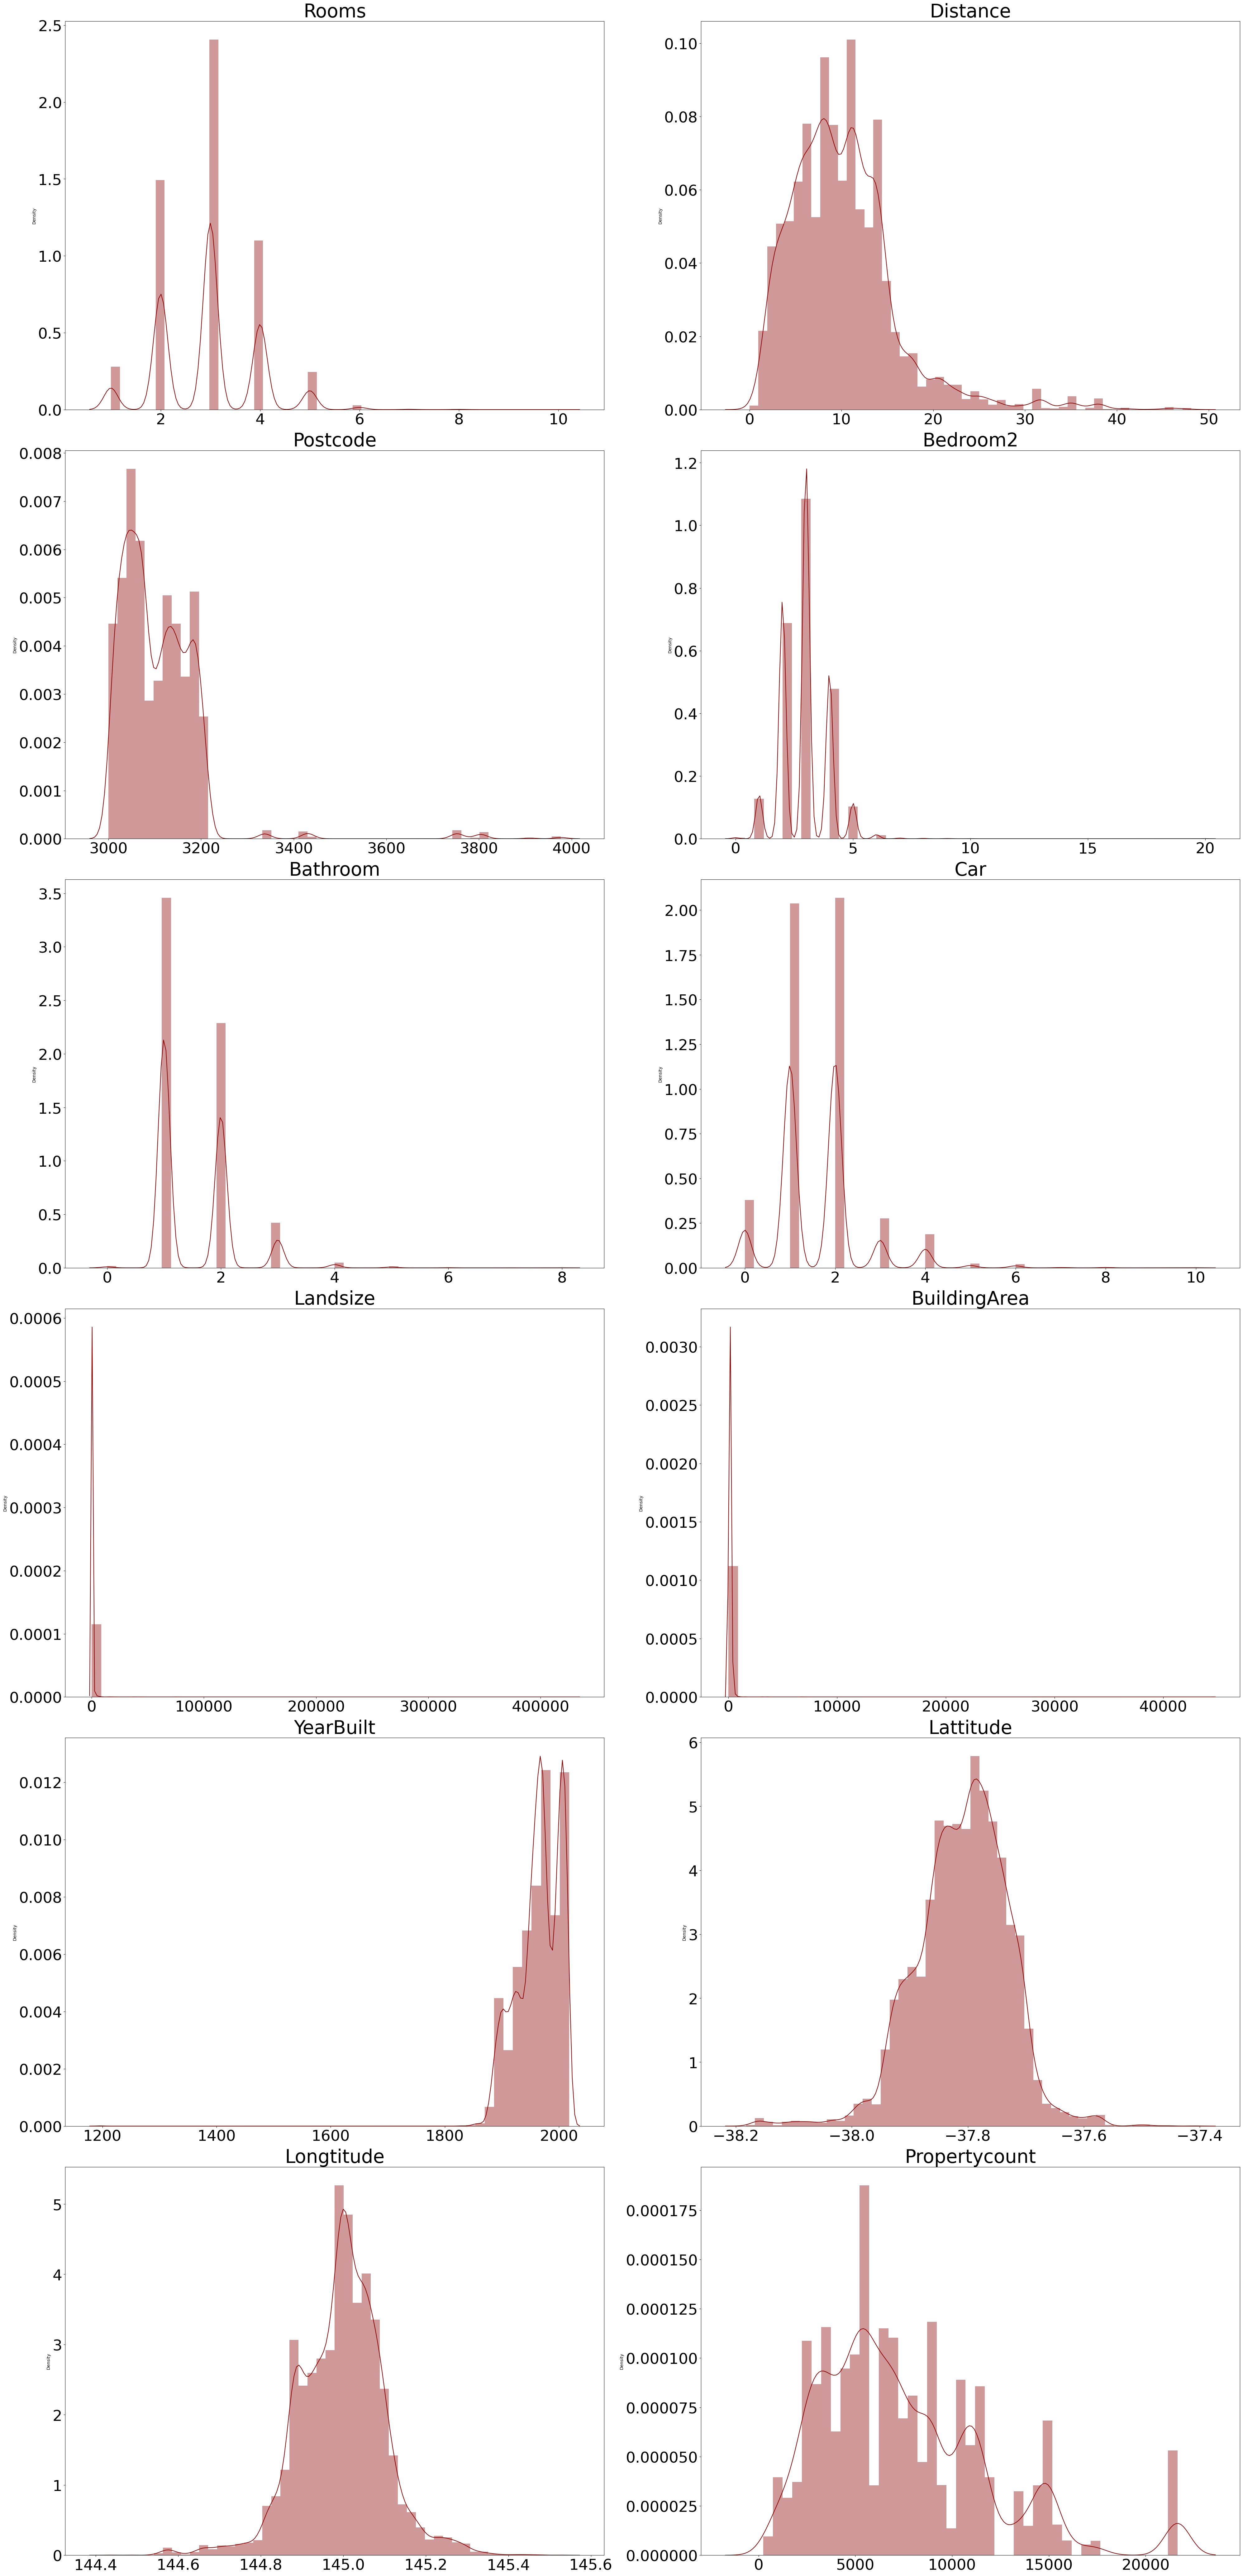

In [8]:
# Select numeric columns from the dataframe df:
numeric_columns = df.select_dtypes(include=['int', 'float'])
distplot(df, numeric_columns)

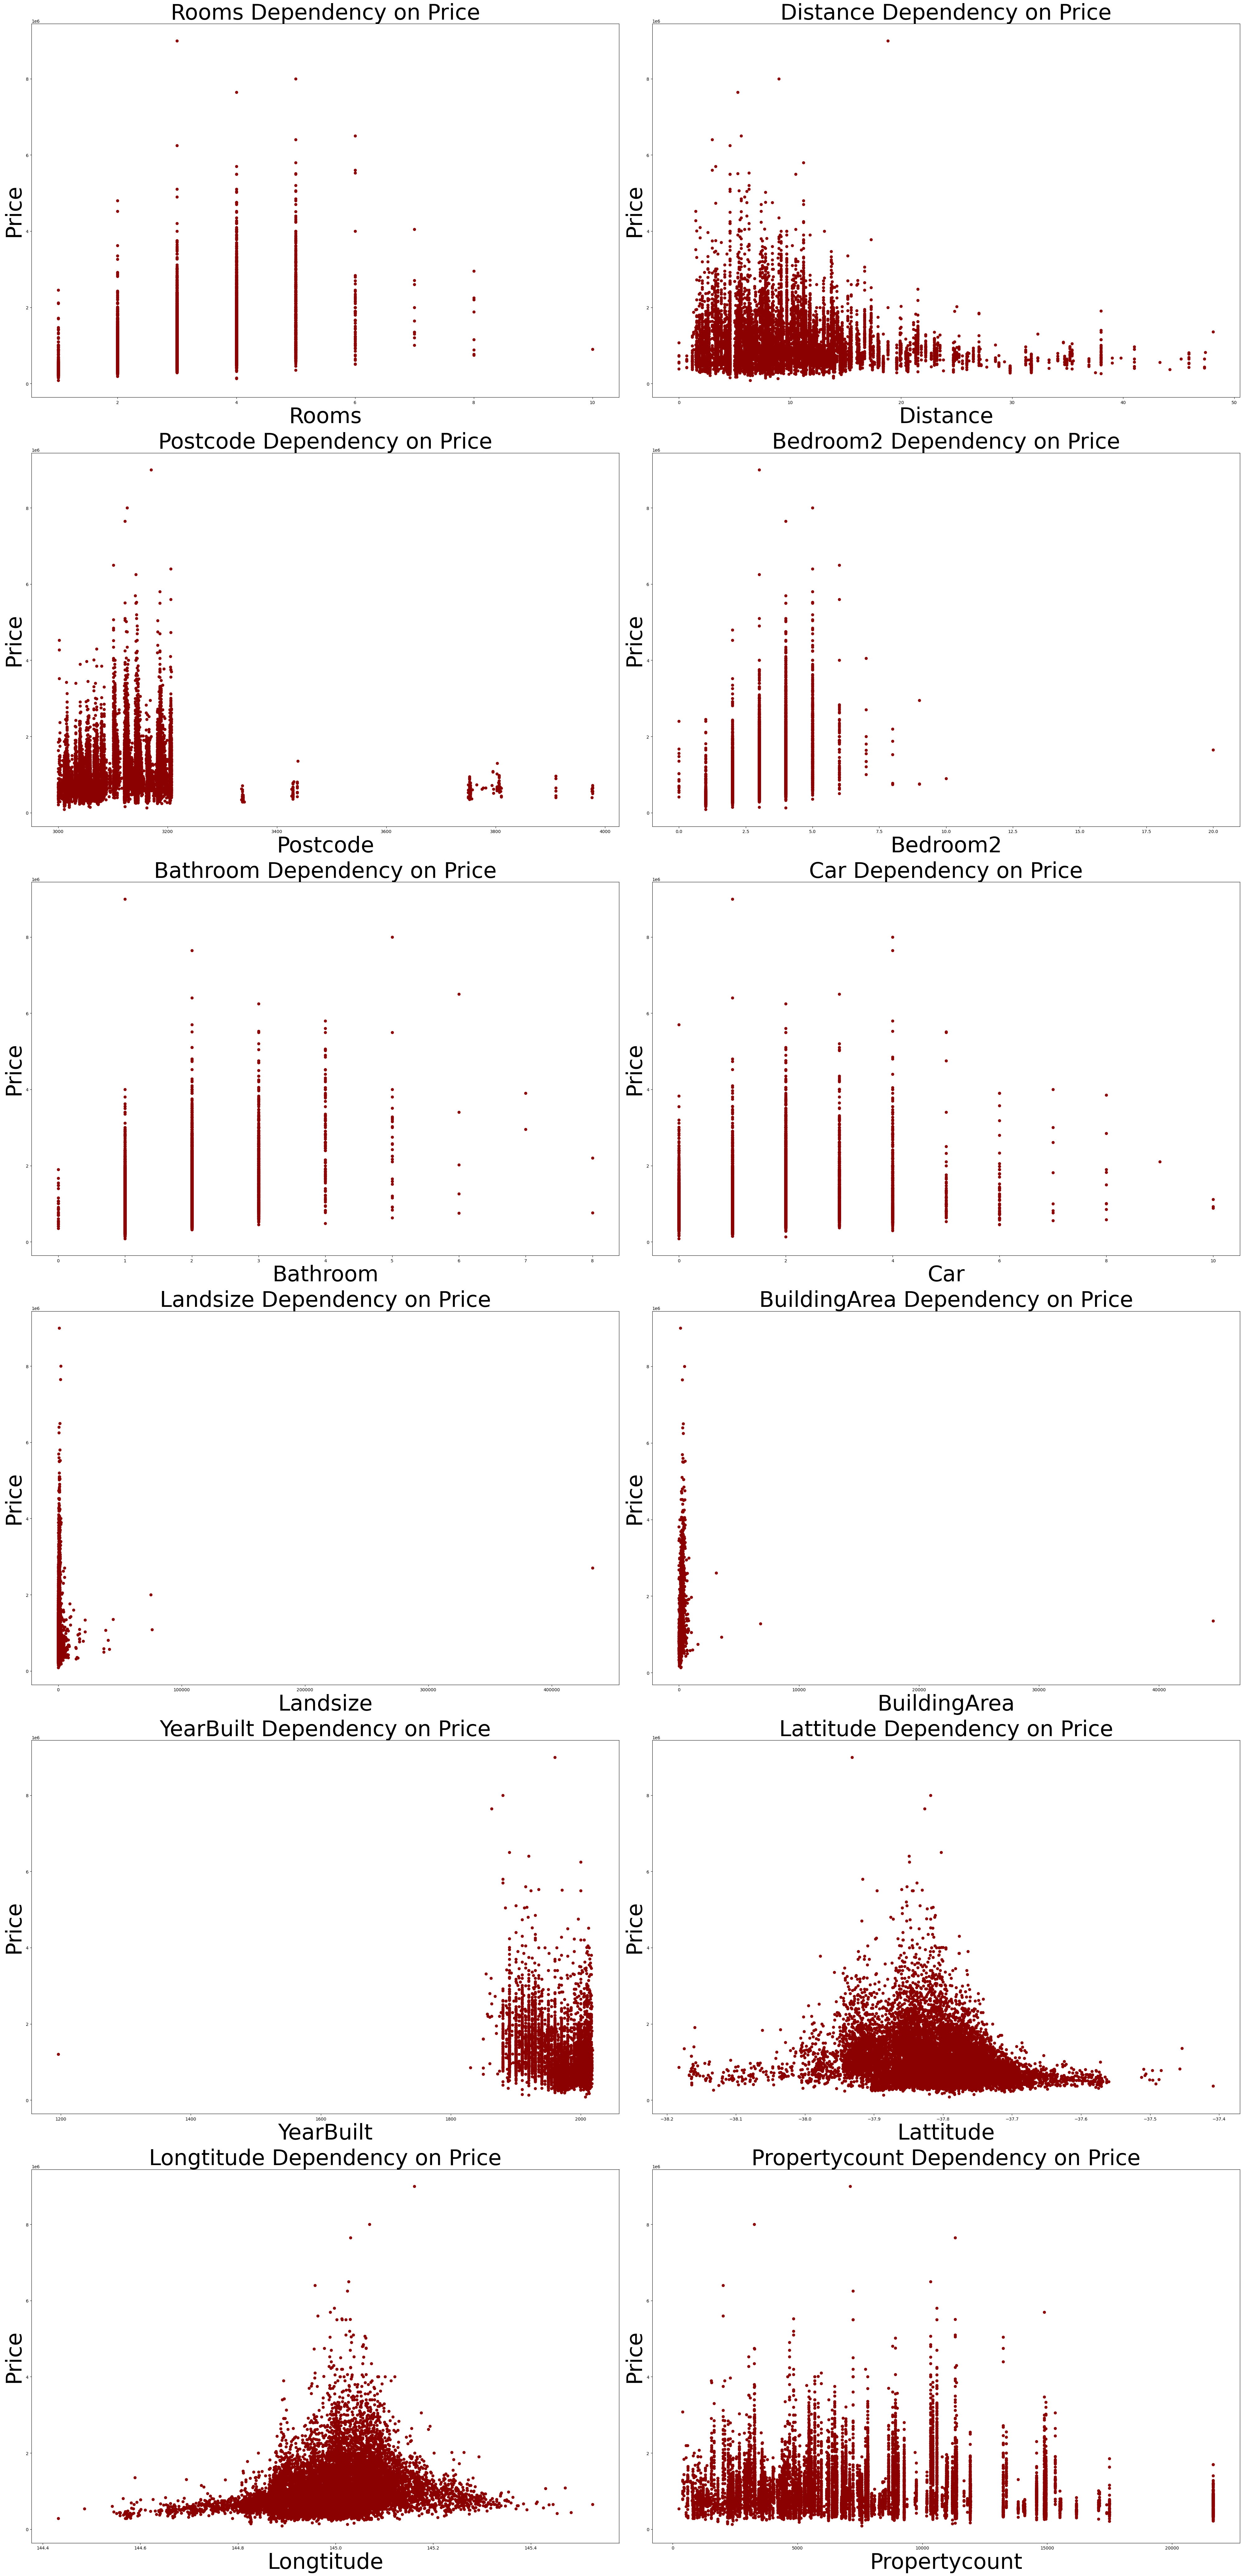

In [9]:
scatterplot(df, numeric_columns)

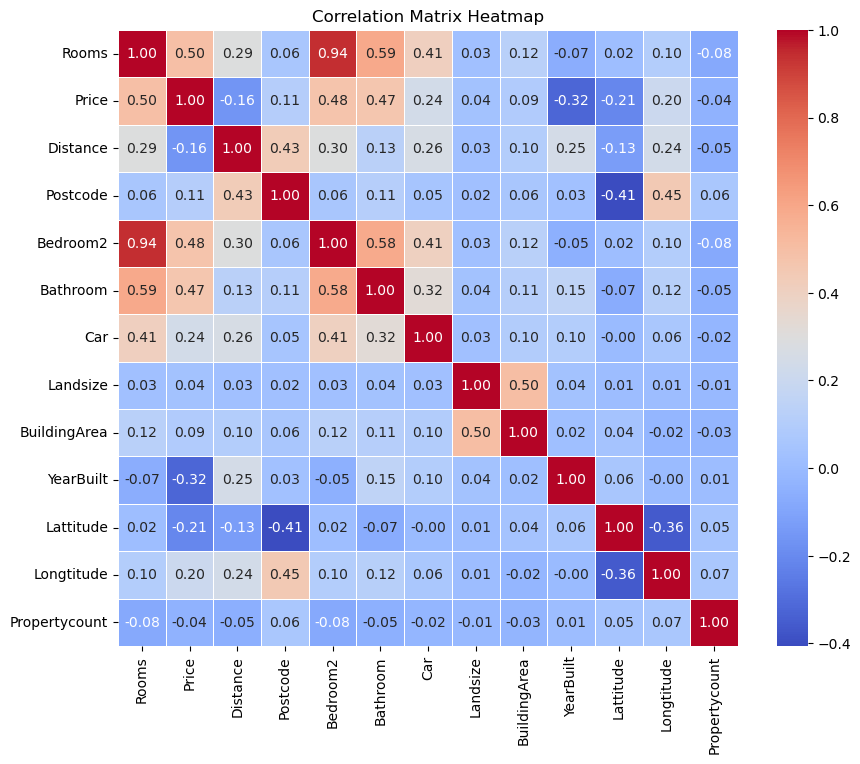

In [10]:
# Calculate the correlation matrix
correlation_matrix = df[numeric_columns.columns].corr()

# Create a figure and set the size for the heatmap
plt.figure(figsize=(10, 8))

# Create a heatmap with annotations and customize its appearance
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix Heatmap")
plt.show()

In [11]:
print(df['Car'].value_counts(), df['BuildingArea'].value_counts(), df['YearBuilt'].value_counts(), \
      df['CouncilArea'].value_counts(), sep='\n\n\n')

Car
2.0     5591
1.0     5509
0.0     1026
3.0      748
4.0      506
5.0       63
6.0       54
8.0        9
7.0        8
10.0       3
9.0        1
Name: count, dtype: int64


BuildingArea
120.00    114
110.00     89
100.00     88
130.00     84
115.00     77
         ... 
129.70      1
665.00      1
398.00      1
148.47      1
553.00      1
Name: count, Length: 602, dtype: int64


YearBuilt
1970.0    866
1960.0    725
1950.0    580
1900.0    341
1980.0    338
         ... 
1901.0      1
1933.0      1
1932.0      1
1893.0      1
1856.0      1
Name: count, Length: 144, dtype: int64


CouncilArea
Moreland             1163
Boroondara           1160
Moonee Valley         997
Darebin               934
Glen Eira             848
Stonnington           719
Maribyrnong           692
Yarra                 647
Port Phillip          628
Banyule               594
Bayside               489
Melbourne             470
Hobsons Bay           434
Brimbank              424
Monash                333
Manningham

In [12]:
# Fill missing values in the 'Car' column with the median of the column
df['Car'].fillna(df['Car'].median(), inplace=True)

# Fill missing values in the 'BuildingArea' column with the mean of the column
df['BuildingArea'].fillna(df['BuildingArea'].mean(), inplace=True)

# Fill missing values in the 'YearBuilt' column with the median of the column
df['YearBuilt'].fillna(df['YearBuilt'].median(), inplace=True)

# Fill missing values in the 'CouncilArea' column with the most common value (mode)
df['CouncilArea'].fillna(df['CouncilArea'].value_counts()[0], inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13580 entries, 0 to 13579
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Suburb         13580 non-null  object 
 1   Address        13580 non-null  object 
 2   Rooms          13580 non-null  int64  
 3   Type           13580 non-null  object 
 4   Price          13580 non-null  float64
 5   Method         13580 non-null  object 
 6   SellerG        13580 non-null  object 
 7   Date           13580 non-null  object 
 8   Distance       13580 non-null  float64
 9   Postcode       13580 non-null  float64
 10  Bedroom2       13580 non-null  float64
 11  Bathroom       13580 non-null  float64
 12  Car            13580 non-null  float64
 13  Landsize       13580 non-null  float64
 14  BuildingArea   13580 non-null  float64
 15  YearBuilt      13580 non-null  float64
 16  CouncilArea    13580 non-null  object 
 17  Lattitude      13580 non-null  float64
 18  Longti

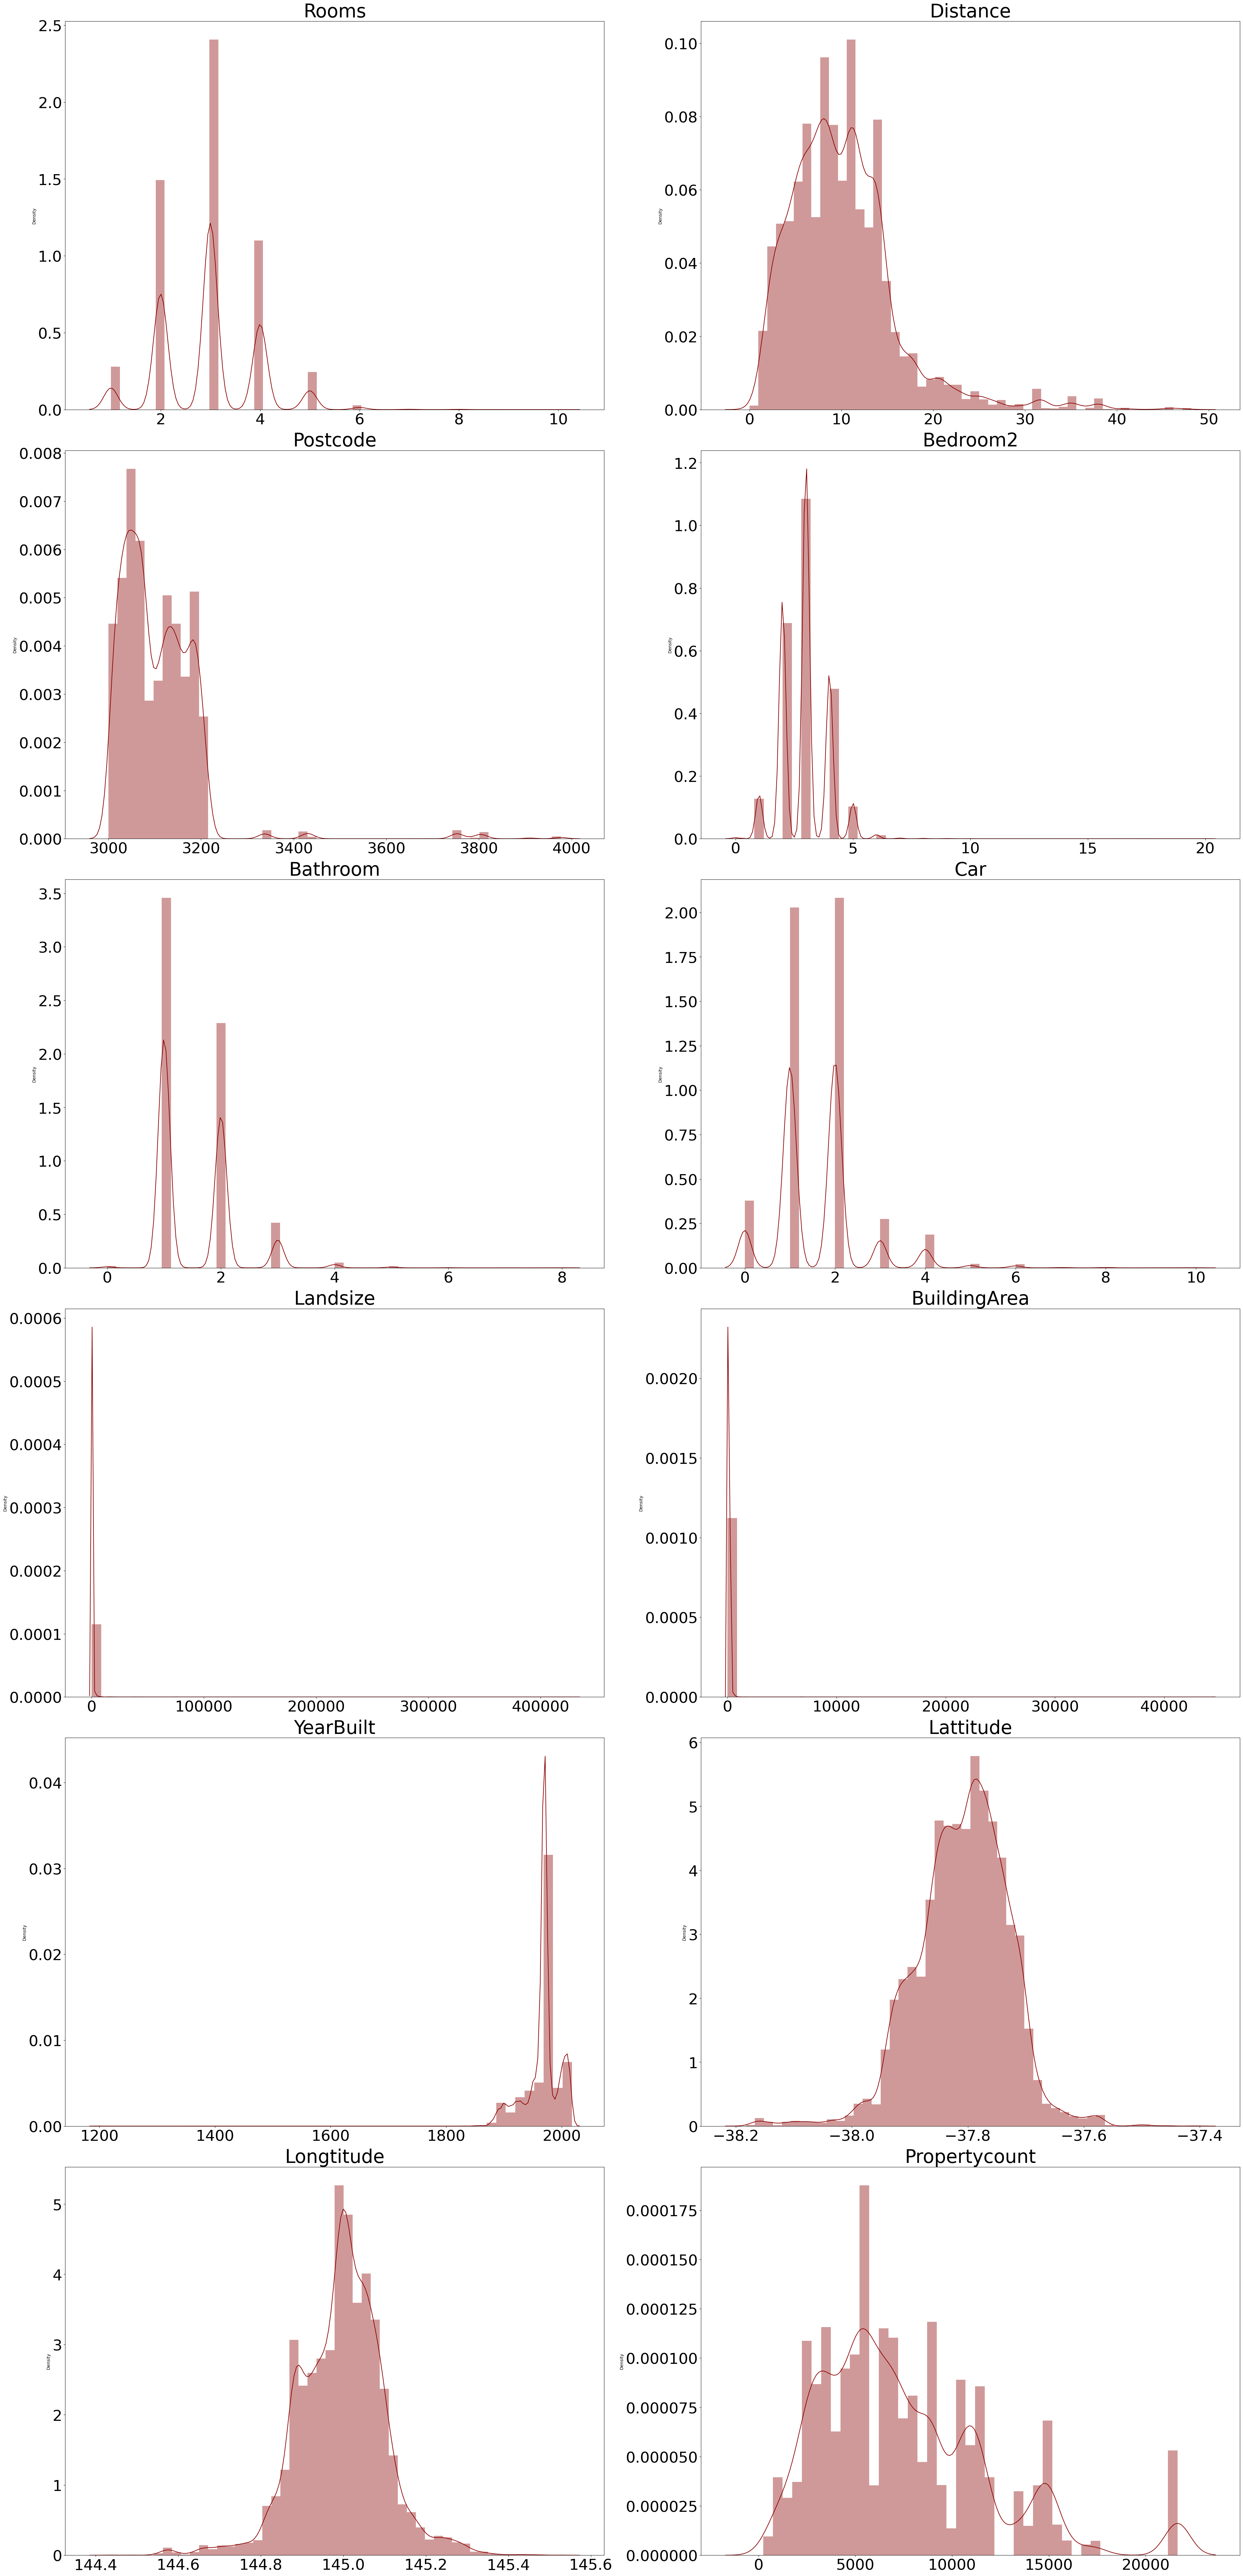

In [13]:
distplot(df, numeric_columns)

In [14]:
# Remove numeric and alphanumeric characters from the 'Address' column using regular expressions
df['Address'] = df['Address'].str.replace(r'[0-9]+[a-zA-Z]*', '', regex=True).str.strip()

# Convert the 'Date' column to a datetime format with the specified format
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')

# Extract the year from the 'Date' column and create a new 'Year' column
df['Year'] = df['Date'].dt.year

# Extract the month from the 'Date' column and create a new 'Month' column
df['Month'] = df['Date'].dt.month

# Extract the weekend information from the Date column and create a new 'Is weekend' column
df['Is weekend'] = df['Date'].apply(is_weekend_or_weekday)

# Drop the original 'Date' column from the DataFrame
df = df.drop('Date', axis=1)
df.head()

Suburb        Address  Rooms Type      Price Method SellerG  Distance  \
0  Abbotsford      Turner St      2    h  1480000.0      S  Biggin       2.5   
1  Abbotsford   Bloomburg St      2    h  1035000.0      S  Biggin       2.5   
2  Abbotsford     Charles St      3    h  1465000.0     SP  Biggin       2.5   
3  Abbotsford  Federation La      3    h   850000.0     PI  Biggin       2.5   
4  Abbotsford        Park St      4    h  1600000.0     VB  Nelson       2.5   

   Postcode  Bedroom2  ...  BuildingArea  YearBuilt  CouncilArea  Lattitude  \
0    3067.0       2.0  ...     151.96765     1970.0        Yarra   -37.7996   
1    3067.0       2.0  ...      79.00000     1900.0        Yarra   -37.8079   
2    3067.0       3.0  ...     150.00000     1900.0        Yarra   -37.8093   
3    3067.0       3.0  ...     151.96765     1970.0        Yarra   -37.7969   
4    3067.0       3.0  ...     142.00000     2014.0        Yarra   -37.8072   

   Longtitude             Regionname  Propertycount  Year Month  Is weekend  
0    144.9984  Northern Metropolitan         4019.0  2016    12           1  
1    144.9934  Northern Metropolitan         4019.0  2016     2           0  
2    144.9944  Northern Metropolitan         4019.0  2017     3           1  
3    144.9969  Northern Metropolitan         4019.0  2017     3           1  
4    144.9941  Northern Metropolitan         4019.0  2016     6           1  

[5 rows x 23 columns]

In [15]:
# Check if the 'Postcode' column exists in the DataFrame
if 'Postcode' in df.columns:
    # If it exists, drop the 'Postcode' column from the DataFrame
    df.drop('Postcode', axis=1, inplace=True)

# Check if the 'Lattitude' column exists in the DataFrame
if 'Lattitude' in df.columns:
    # If it exists, drop the 'Lattitude' column from the DataFrame
    df.drop('Lattitude', axis=1, inplace=True)

# Check if the 'Longtitude' column exists in the DataFrame
if 'Longtitude' in df.columns:
    # If it exists, drop the 'Longtitude' column from the DataFrame
    df.drop('Longtitude', axis=1, inplace=True)

# Check if the 'Suburb' column exists in the DataFrame
if 'Suburb' in df.columns:
    # If it exists, drop the 'Suburb' column from the DataFrame
    df.drop('Suburb', axis=1, inplace=True)
df.head()

Address  Rooms Type      Price Method SellerG  Distance  Bedroom2  \
0      Turner St      2    h  1480000.0      S  Biggin       2.5       2.0   
1   Bloomburg St      2    h  1035000.0      S  Biggin       2.5       2.0   
2     Charles St      3    h  1465000.0     SP  Biggin       2.5       3.0   
3  Federation La      3    h   850000.0     PI  Biggin       2.5       3.0   
4        Park St      4    h  1600000.0     VB  Nelson       2.5       3.0   

   Bathroom  Car  Landsize  BuildingArea  YearBuilt CouncilArea  \
0       1.0  1.0     202.0     151.96765     1970.0       Yarra   
1       1.0  0.0     156.0      79.00000     1900.0       Yarra   
2       2.0  0.0     134.0     150.00000     1900.0       Yarra   
3       2.0  1.0      94.0     151.96765     1970.0       Yarra   
4       1.0  2.0     120.0     142.00000     2014.0       Yarra   

              Regionname  Propertycount  Year  Month  Is weekend  
0  Northern Metropolitan         4019.0  2016     12           1  
1  Northern Metropolitan         4019.0  2016      2           0  
2  Northern Metropolitan         4019.0  2017      3           1  
3  Northern Metropolitan         4019.0  2017      3           1  
4  Northern Metropolitan         4019.0  2016      6           1

In [16]:
# Define a list of categorical columns to be one-hot encoded
categorical_cols = ['Address', 'Type', 'Method', 'CouncilArea', 'SellerG', 'Regionname', 'YearBuilt', 'Year', 
                    'Month', 'Is weekend']

# Create a new DataFrame 'df_encoded' by applying one-hot encoding to the selected categorical columns
encoded_df = pd.get_dummies(df[categorical_cols].astype(str), columns=categorical_cols)

# Concatenate the one-hot encoded columns with the original DataFrame, dropping the original categorical columns
# This creates a new DataFrame 'encoded_df' with one-hot encoded categorical variables and the remaining numerical columns
encoded_df = pd.concat([df.drop(categorical_cols, axis=1), encoded_df], axis=1).astype(int)
encoded_df.head()

Rooms    Price  Distance  Bedroom2  Bathroom  Car  Landsize  BuildingArea  \
0      2  1480000         2         2         1    1       202           151   
1      2  1035000         2         2         1    0       156            79   
2      3  1465000         2         3         2    0       134           150   
3      3   850000         2         3         2    1        94           151   
4      4  1600000         2         3         1    2       120           142   

   Propertycount  Address_/ Abbotsford Gr  ...  Month_2  Month_3  Month_4  \
0           4019                        0  ...        0        0        0   
1           4019                        0  ...        1        0        0   
2           4019                        0  ...        0        1        0   
3           4019                        0  ...        0        1        0   
4           4019                        0  ...        0        0        0   

   Month_5  Month_6  Month_7  Month_8  Month_9  Is weekend_0  Is weekend_1  
0        0        0        0        0        0             0             1  
1        0        0        0        0        0             1             0  
2        0        0        0        0        0             0             1  
3        0        0        0        0        0             0             1  
4        0        1        0        0        0             0             1  

[5 rows x 6725 columns]

In [17]:
#label_encoder = LabelEncoder()
#
#for column in df.select_dtypes(include=['object']):
#    df[column] = df[column].astype(str)
#    df[column] = label_encoder.fit_transform(df[column])
#df.head()

In [18]:
# Split the DataFrame into features (X) and the target variable (y)
X = encoded_df.drop('Price', axis=1)
y = encoded_df['Price']

# Split the data into training and testing sets using train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [19]:
# Create a Linear Regression model
model = LinearRegression()

# Train (fit) the model using the training data
model.fit(X_train, y_train)

# Use the trained model to make predictions on the train data
y_pred_train = model.predict(X_train)

# Calculate the Mean Squared Error (MSE) to assess the model's performance
mse_train = mean_squared_error(y_train, y_pred_train)

# Calculate the R-squared (R^2) score to assess how well the model fits the data
r2_train = r2_score(y_train, y_pred_train)

# Print the best model performance
print(f"Train: R-squared (R^2) Score: {r2_train}")
print(f"Train: Mean Squared Error (MSE): {mse_train}")

# Use the trained model to make predictions on the test data
y_pred_test = model.predict(X_test)

# Calculate the Mean Squared Error (MSE) to assess the model's performance
mse_test = mean_squared_error(y_test, y_pred_test)

# Calculate the R-squared (R^2) score to assess how well the model fits the data
r2_test = r2_score(y_test, y_pred_test)

# Print the best model performance
print(f"Test: R-squared (R^2) Score: {r2_test}")
print(f"Test: Mean Squared Error (MSE): {mse_test}")

Train: R-squared (R^2) Score: 0.8821540153615146
Train: Mean Squared Error (MSE): 48499996026.22382
Test: R-squared (R^2) Score: 0.6137605952202531
Test: Mean Squared Error (MSE): 153419642558.5499


In [20]:
# Create a Ridge model
model = Ridge(alpha=4)

# Train (fit) the model using the training data
model.fit(X_train, y_train)

# Use the trained model to make predictions on the train data
y_pred_train = model.predict(X_train)

# Calculate the Mean Squared Error (MSE) to assess the model's performance
mse_train = mean_squared_error(y_train, y_pred_train)

# Calculate the R-squared (R^2) score to assess how well the model fits the data
r2_train = r2_score(y_train, y_pred_train)

# Print the best model performance
print(f"Train: R-squared (R^2) Score: {r2_train}")
print(f"Train: Mean Squared Error (MSE): {mse_train}")

# Use the trained model to make predictions on the test data
y_pred_test = model.predict(X_test)

# Calculate the Mean Squared Error (MSE) to assess the model's performance
mse_test = mean_squared_error(y_test, y_pred_test)

# Calculate the R-squared (R^2) score to assess how well the model fits the data
r2_test = r2_score(y_test, y_pred_test)

# Print the best model performance
print(f"Test: R-squared (R^2) Score: {r2_test}")
print(f"Test: Mean Squared Error (MSE): {mse_test}")

Train: R-squared (R^2) Score: 0.7681830543024877
Train: Mean Squared Error (MSE): 95405210280.44421
Test: R-squared (R^2) Score: 0.6857348822926175
Test: Mean Squared Error (MSE): 124830458598.03333


In [21]:
# Create a XGBRegressor model
model = xgb.XGBRegressor(booster='gblinear', eval_metric='rmse', reg_lambda=0.1, n_estimators=1000)

# Train (fit) the model using the training data
model.fit(X_train, y_train)

# Use the trained model to make predictions on the train data
y_pred_train = model.predict(X_train)

# Calculate the Mean Squared Error (MSE) to assess the model's performance
mse_train = mean_squared_error(y_train, y_pred_train)

# Calculate the R-squared (R^2) score to assess how well the model fits the data
r2_train = r2_score(y_train, y_pred_train)

# Print the best model performance
print(f"Train: R-squared (R^2) Score: {r2_train}")
print(f"Train: Mean Squared Error (MSE): {mse_train}")

# Use the trained model to make predictions on the test data
y_pred_test = model.predict(X_test)

# Calculate the Mean Squared Error (MSE) to assess the model's performance
mse_test = mean_squared_error(y_test, y_pred_test)

# Calculate the R-squared (R^2) score to assess how well the model fits the data
r2_test = r2_score(y_test, y_pred_test)

# Print the best model performance
print(f"Test: R-squared (R^2) Score: {r2_test}")
print(f"Test: Mean Squared Error (MSE): {mse_test}")

Train: R-squared (R^2) Score: 0.5922277884048464
Train: Mean Squared Error (MSE): 167820318211.42618
Test: R-squared (R^2) Score: 0.6175070103827982
Test: Mean Squared Error (MSE): 151931514552.96393


In [22]:
# Create a CustomLinearRegression model
model = CustomLinearRegression()

# Train (fit) the model using the training data
model.fit(X_train[['Rooms', 'Distance', 'Bedroom2', 'Bathroom', 'Car', 'Landsize', 'BuildingArea', 
                   'Propertycount']], y_train)

# Use the trained model to make predictions on the train data
y_pred_train = model.predict(X_train[['Rooms', 'Distance', 'Bedroom2', 'Bathroom', 'Car', 'Landsize', 
                                      'BuildingArea', 'Propertycount']])

# Calculate the Mean Squared Error (MSE) to assess the model's performance
mse_train = mean_squared_error(y_train, y_pred_train)

# Calculate the R-squared (R^2) score to assess how well the model fits the data
r2_train = r2_score(y_train, y_pred_train)

# Print the best model performance
print(f"Train: R-squared (R^2) Score: {r2_train}")
print(f"Train: Mean Squared Error (MSE): {mse_train}")

# Use the trained model to make predictions on the test data
y_pred_test = model.predict(X_test[['Rooms', 'Distance', 'Bedroom2', 'Bathroom', 'Car', 'Landsize', 'BuildingArea', 
                   'Propertycount']])

# Calculate the Mean Squared Error (MSE) to assess the model's performance
mse_test = mean_squared_error(y_test, y_pred_test)

# Calculate the R-squared (R^2) score to assess how well the model fits the data
r2_test = r2_score(y_test, y_pred_test)

# Print the best model performance
print(f"Test: R-squared (R^2) Score: {r2_test}")
print(f"Test: Mean Squared Error (MSE): {mse_test}")

Train: R-squared (R^2) Score: 0.3896325299473309
Train: Mean Squared Error (MSE): 251199223825.08786
Test: R-squared (R^2) Score: 0.40671787357459444
Test: Mean Squared Error (MSE): 235659879976.42792


In [23]:
# Create a Linear Regression model
model = LinearRegression()

# Train (fit) the model using the training data
model.fit(X_train[['Rooms', 'Distance', 'Bedroom2', 'Bathroom', 'Car', 'Landsize', 'BuildingArea', 
                   'Propertycount']], y_train)

# Use the trained model to make predictions on the train data
y_pred_train = model.predict(X_train[['Rooms', 'Distance', 'Bedroom2', 'Bathroom', 'Car', 'Landsize', 
                                      'BuildingArea', 'Propertycount']])

# Calculate the Mean Squared Error (MSE) to assess the model's performance
mse_train = mean_squared_error(y_train, y_pred_train)

# Calculate the R-squared (R^2) score to assess how well the model fits the data
r2_train = r2_score(y_train, y_pred_train)

# Print the best model performance
print(f"Train: R-squared (R^2) Score: {r2_train}")
print(f"Train: Mean Squared Error (MSE): {mse_train}")

# Use the trained model to make predictions on the test data
y_pred_test = model.predict(X_test[['Rooms', 'Distance', 'Bedroom2', 'Bathroom', 'Car', 'Landsize', 'BuildingArea', 
                                    'Propertycount']])

# Calculate the Mean Squared Error (MSE) to assess the model's performance
mse_test = mean_squared_error(y_test, y_pred_test)

# Calculate the R-squared (R^2) score to assess how well the model fits the data
r2_test = r2_score(y_test, y_pred_test)

# Print the best model performance
print(f"Test: R-squared (R^2) Score: {r2_test}")
print(f"Test: Mean Squared Error (MSE): {mse_test}")

Train: R-squared (R^2) Score: 0.3896325299473309
Train: Mean Squared Error (MSE): 251199223825.08786
Test: R-squared (R^2) Score: 0.40671787357455924
Test: Mean Squared Error (MSE): 235659879976.44193


In [24]:
#model = Ridge()

#param_grid = {
#    'alpha': np.logspace(-6, 2, 13),
#}

#grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error')

#grid_search.fit(X_train, y_train)

#best_model = grid_search.best_estimator_

#y_pred = best_model.predict(X_test)

#r2 = r2_score(y_test, y_pred)
#mse = mean_squared_error(y_test, y_pred)

#print("Best params: ", grid_search.best_params_)
#print("Best Model - R-squared (R^2) Score:", r2)
#print("Best Model - Mean Squared Error (MSE):", mse)

In [25]:
#model = xgb.XGBRegressor(booster='gblinear', eval_metric='rmse')

#param_grid = {
#    'learning_rate': np.logspace(-6, -1, 13),
#    'reg_lambda': np.logspace(-6, 2, 13),
#    'n_estimators': [50, 100, 200],
#}

#grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error')

#grid_search.fit(X_train, y_train)

#best_model = grid_search.best_estimator_

#y_pred = best_model.predict(X_test)

#mse = mean_squared_error(y_test, y_pred)
#r2 = r2_score(y_test, y_pred)

#print("Best params: ", grid_search.best_params_)
#print("Best Model - R-squared (R^2) Score:", r2)
#print("Best Model - Mean Squared Error (MSE):", mse)